In [1]:
from math import ceil, log
from functools import reduce
import re

from scipy.stats import linregress as linear_regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.precision", 16)


In [194]:
class DBMeta(object):
    
    def __init__(self, T, K, Z, B, E, bpe, L, phi=1):
        self.T, self.K, self.Z, self.B, self.E, self.L = int(T), int(K), int(Z), int(B), int(E), int(L)
        self.bpe, self.phi = bpe, phi
        self.is_tiering = True if (K == T - 1) else False
        self.N = self.estimate_N()
        self.mfilt = int(self.bpe * self.N) >> 3
            
    def estimate_N(self):
        num_entries = 0
        for level in range(1, int(self.L) + 1):
            num_entries += (self.B / self.E) * (self.T - 1) * (self.T ** (level - 1))

        return num_entries
        
    def level(self):

        return ceil(log((self.N * self.E) / self.B + 1, self.T))
    
    def write_cost(self):
        cost = self.T * (1 + self.phi) * (self.L / self.B)
        cost /= self.T if self.is_tiering else 2

        return cost
    
    def fp(self, curr_level):
        alpha = (self.T ** (self.T / (self.T - 1))) / (self.T ** (self.L + 1 - curr_level))

        return alpha * (np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N))
    
    def non_empty_read_cost(self):
        cost = 0
        run_probs = [self.B * (self.T ** (i)) / (self.E * self.N) for i in range(0, self.L)]
        fp_levels = [self.fp(i + 1) for i in range(0, self.L)]
        fp_levels_sum = [0] + list(np.cumsum(fp_levels))
        if self.is_tiering:
            for i in range(0, self.L):
                for r in range(1, self.T):
                    cost += run_probs[i] * (1 + (self.T - 1) * fp_levels_sum[i] + (r - 1) * fp_levels[i])
        else:
            for i in range(0 , self.L):
                cost += (self.T - 1) * run_probs[i] * (1 + fp_levels_sum[i])

        return cost
    
    def old_non_empty_read_cost(self):
        cost = 1 + self.empty_read_cost() 
        sub = np.e ** ((-1 * self.mfilt * (np.log(2) ** 2) / (self.N * self.L)) + (1 / (self.L * (self.T - 1))))
        if self.is_tiering:
            sub *= (self.T / (2 * (self.T - 1)))
        cost -= sub

        return cost
    
    def empty_read_cost(self):
        if self.is_tiering:
            alpha = self.T ** (self.T / (self.T - 1))
        else:
            alpha = (self.T ** (self.T / (self.T - 1))) / (self.T - 1)
        beta = np.e ** (-1 * self.mfilt * (np.log(2) ** 2) / self.N)

        return alpha * beta

    def dost_write_cost(self):

        return (1 / self.B) * (((self.T - 1) * (self.level() - 1) / (self.K + 1)) + (self.T - 1) / (self.Z + 1))

# Generating Data

In [208]:
def set_style():
    # This sets reasonable defaults for font size for a paper
    sns.set_context("paper")    
    # Set the font to be serif
    sns.set(font='serif')#, rc={'text.usetex' : True})   
    # Make the background white, and specify the specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    # Set tick size for axes
    sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})
    
    fsz = 14
    plt.rc('font', size=fsz)
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)

def plot_old_new_model(df, xaxis='T'): 
    is_tiering = df.iloc[-1]['is_tiering']
    fig, ax = plt.subplots(figsize=(15,5))
    
    ax.set_xlabel(xaxis)
    ax.set_ylabel('Expected I/Os')
    ax.plot(df[xaxis], df['model_non_empty_read_cost'], color='red')
    ax.plot(df[xaxis], df['old_non_empty_read_cost'], color='black')
    ax.axhline(y=1, color='black', alpha=0.5, linestyle='--')
    ax.tick_params(axis='y')
    ax.set_ylim(bottom=0)
    ax.legend(['New', 'Old'])

    
    B, E = df.iloc[-1][['B', 'E']]
    title = [
        f'Buffer, Entry, Policy : ({B / (1 << 20)} MB, {E / (1 << 10)} KB, {"Tiering" if is_tiering else "Leveling"})'
    ]
        
    ax.set_title('\n'.join(title))
    
    return fig

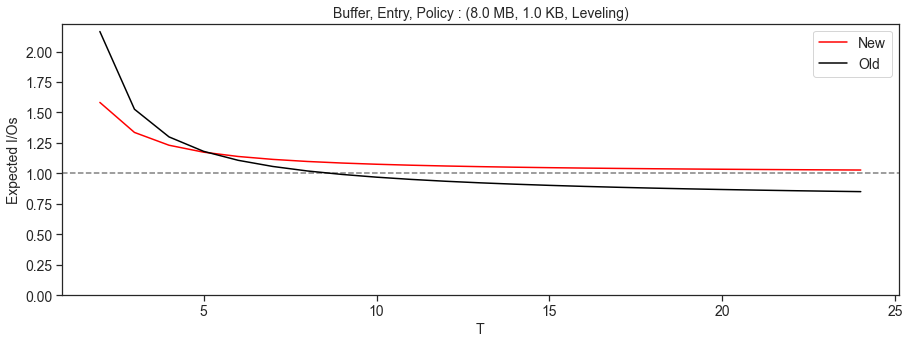

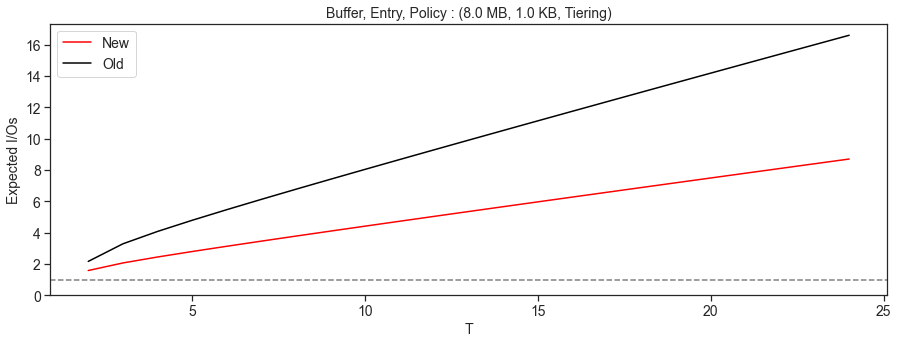

In [219]:
def row(T=2, K=1, Z=1, L=3, B=(8*1048576), E=1024, bpe=9.0, is_tiering=False):
    return {'T' : T, 'K' : K, 'Z' : Z, 'L' : L, 'B' : B, 'E' : E, 'bpe' : bpe, 'is_tiering' : is_tiering} 

MIN_T, MAX_T = 2, 25
set_style()

df = [row(T=T, K=1, Z=1, is_tiering=False) for T in range(MIN_T, MAX_T)]
df = pd.DataFrame(df)
df['model_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).non_empty_read_cost(), axis=1)
df['old_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).old_non_empty_read_cost(), axis=1)

_ = plot_old_new_model(df, 'T')

df = [row(T=T, K=T-1, Z=T-1, is_tiering=True) for T in range(MIN_T, MAX_T)]
df = pd.DataFrame(df)
df['model_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).non_empty_read_cost(), axis=1)
df['old_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).old_non_empty_read_cost(), axis=1)

_ = plot_old_new_model(df, 'T')

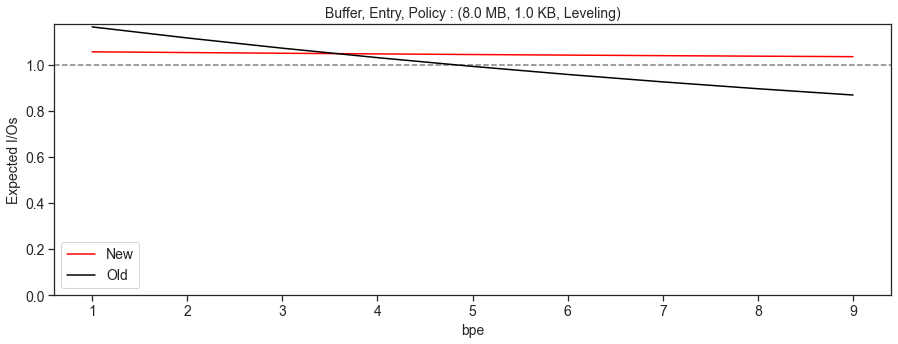

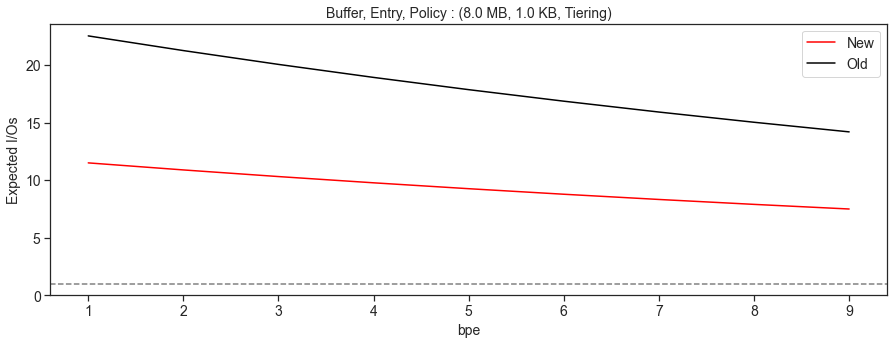

In [222]:
set_style()
MIN_BPE, MAX_BPE = 1, 10
T = 20

df = [row(T=T, K=1, Z=1, is_tiering=False, bpe=bpe) for bpe in range(MIN_BPE, MAX_BPE)]
df = pd.DataFrame(df)
df['model_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).non_empty_read_cost(), axis=1)
df['old_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).old_non_empty_read_cost(), axis=1)

_ = plot_old_new_model(df, 'bpe')

df = [row(T=T, K=T-1, Z=T-1, is_tiering=True, bpe=bpe) for bpe in range(MIN_BPE, MAX_BPE)]
df = pd.DataFrame(df)
df['model_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).non_empty_read_cost(), axis=1)
df['old_non_empty_read_cost'] = df.apply(lambda row: DBMeta(row['T'], row['K'], row['Z'], row['B'], row['E'], row['bpe'], row['L']).old_non_empty_read_cost(), axis=1)

_ = plot_old_new_model(df, 'bpe')